# 5.6 Bidirectional RNNs

Course's materials require a `tensorflow` version lower than the default one used in Google Colab. Run the following cell to downgrade TensorFlow accordingly.

In [ ]:
import os
def downgrade_tf_version():
    os.system("!yes | pip uninstall -y tensorflow")
    os.system("!yes | pip install tensorflow==2.12.0")
    os.kill(os.getpid(), 9)
downgrade_tf_version()

In [ ]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
    %load_ext tensorboard
import tensorflow as tf
tf.__version__

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Embedding, Activation, RepeatVector, Bidirectional, Concatenate, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In some problems the information required to make a prediction in one point of a sequence, includes not only pass information but also "future" information, i.e., information before and after of the target point in the sequence. This also implies that such informaction must be available to make the perdictions. For instance, in translation problems usually you need to know an entire sentence beforhand in order to translate it correctly.   The bidirectional RNNs are a modification of the standard RNNs that incorporate additional layers which transmit the information from the time $t+1$ to the time $t$. The forward and backward layers do not have any conextion among them. 

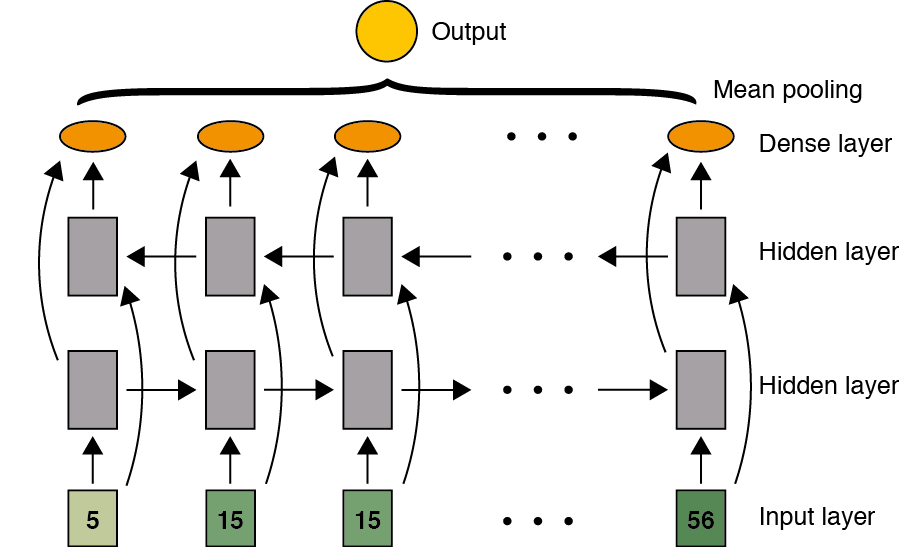

In [6]:
from IPython.display import Image
Image(filename='local/imgs/RNN_arc_3.png', width=1200)
#![alt text](./Images/RNN_arc_3.png "Neuronas")

## Neural Machine Translation

This example is based on the Machine Translation material included in the Deep Learning Specilization offered by Coursera: https://es.coursera.org/specializations/deep-learning

The following model architecture could be used for a full language translation problem, however it would require hundred of thousands of texts, a big computational power (GPU) and hundreds of hours in order to get a fairly accurate model. Therefore, we are going to use a medium sized datase that includes 118964 sentences in English and Spanish.

In [4]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation

    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [6]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    return zip(*word_pairs)


In [8]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [9]:
len(en),len(sp)

(118964, 118964)

In [10]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### Tokenize

In [11]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    targ_lang, inp_lang = create_dataset(path, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
    
    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Optional

In [12]:
# Try experimenting with the size of that dataset
num_examples = len(en)#30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [13]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

95171 95171 23793 23793


In [18]:
len(inp_lang.index_word)

24793

In [19]:
len(targ_lang.index_word)

12933

In order to see the actual Spanish translation, it is necessary to define a function to decode the network's output.

In [14]:
def convert(lang, tensor):
    for t in tensor:
        if t!=0:
            print ("%d ----> %s" % (t, lang.index_word[t]))

In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
20 ----> por
1929 ----> supuesto
84 ----> !
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
18 ----> of
1209 ----> course
119 ----> !
2 ----> <end>


In [16]:
input_tensor_train.shape, target_tensor_train.shape

((95171, 53), (95171, 51))

In [17]:
np.expand_dims(input_tensor_train, axis=2).shape

(95171, 53, 1)

### Create a tf.data dataset

For the simplest models, the size of input and output sequences must be equal! 

In [18]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((np.expand_dims(input_tensor_train, axis=2), np.expand_dims(np.c_[target_tensor_train,np.zeros((target_tensor_train.shape[0],input_tensor_train.shape[1]-target_tensor_train.shape[1]))], axis=2))).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [19]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53, 1]), TensorShape([64, 53, 1]))

In [20]:
def evaluate1(sentence,model):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    out = model.predict(inputs)
    words = out.argmax(axis=-1)
    for t in words[0]:
        if t!=0:
            result += targ_lang.index_word[t] + ' '
    return result

### Simple RNN network

Pay attention to the output format and the loss function.

In [21]:
input_tensor_train.shape[1]

53

In [22]:
def simple_model(input_shape, output_sequence_length, spanish_vocab_size, english_vocab_size):
    learning_rate = 0.001
    input_seq = Input([input_shape[1],1])
    rnn = LSTM(128, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(english_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss = 'sparse_categorical_crossentropy', 
                 optimizer = Adam(learning_rate))
    
    return model

# Train the neural network
simple_rnn_model = simple_model(
    input_tensor_train.shape,
    target_tensor_train.shape[1],
    vocab_inp_size,
    vocab_tar_size)
simple_rnn_model.fit(dataset, epochs=50, verbose=1)

Epoch 1/50
1487/1487 [==============================] - 21s 13ms/step - loss: 1.7278
Epoch 2/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.8353
Epoch 3/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.8065
Epoch 4/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7849
Epoch 5/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7667
Epoch 6/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7551
Epoch 7/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7422
Epoch 8/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7314
Epoch 9/50
1487/1487 [==============================] - 18s 12ms/step - loss: 0.7216
Epoch 10/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7123
Epoch 11/50
1487/1487 [==============================] - 19s 13ms/step - loss: 0.7078
Epoch 12/50
1487/1487 [==============================] - 19s 13

In [23]:
simple_rnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 53, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 53, 128)           66560     
_________________________________________________________________
time_distributed (TimeDistri (None, 53, 12934)         1668486   
_________________________________________________________________
activation (Activation)      (None, 53, 12934)         0         
Total params: 1,735,046
Trainable params: 1,735,046
Non-trainable params: 0
_________________________________________________________________


In [24]:
sentence = u'hace mucho frio en este lugar.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,simple_rnn_model)
print(result)

<start> hace mucho frio en este lugar . <end>
<start> i ve never in in in . . 


In [25]:
sentence = u'esta es mi vida.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,simple_rnn_model)
print(result)

<start> esta es mi vida . <end>
<start> i is my dog . <end> 


## Using word2vec

In [26]:
def embed_model(input_shape, output_sequence_length, spanish_vocab_size, english_vocab_size):
    learning_rate = 0.001
    rnn = LSTM(128, return_sequences=True, activation="relu")
    
    embedding = Embedding(spanish_vocab_size, 64, input_length=input_shape[1]) 
    logits = TimeDistributed(Dense(english_vocab_size, activation="softmax"))
    
    model = Sequential()
    #em can only be used in first layer --> Keras Documentation
    model.add(embedding)
    model.add(rnn)
    model.add(logits)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=Adam(learning_rate))
    
    return model


embeded_model = embed_model(
    input_tensor_train.shape,
    target_tensor_train.shape[1],
    vocab_inp_size,
    vocab_tar_size)

embeded_model.fit(dataset, epochs=50, verbose=1)

Epoch 1/50
1487/1487 [==============================] - 64s 42ms/step - loss: 1.8983
Epoch 2/50
1487/1487 [==============================] - 63s 42ms/step - loss: 0.8322
Epoch 3/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.7871
Epoch 4/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.7457
Epoch 5/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.6958
Epoch 6/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.7349
Epoch 7/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.6359
Epoch 8/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.6000
Epoch 9/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.6514
Epoch 10/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.5742
Epoch 11/50
1487/1487 [==============================] - 61s 41ms/step - loss: 0.5382
Epoch 12/50
1487/1487 [==============================] - 61s 41

In [27]:
sentence = u'hace mucho frio en este lugar.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,embeded_model)
print(result)

<start> hace mucho frio en este lugar . <end>
<start> i many cold in in . . <end> 


In [28]:
sentence = u'esta es mi vida.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,embeded_model)
print(result)

<start> esta es mi vida . <end>
<start> this is my life . <end> 


## Bidirectional RNN

In [29]:
def bd_model(input_shape, output_sequence_length, spanish_vocab_size, english_vocab_size):
   
    learning_rate = 0.001
    model = Sequential()
    model.add(Embedding(spanish_vocab_size, 64, input_length=input_shape[1])) 
    model.add(Bidirectional(LSTM(128, return_sequences = True, dropout = 0.1)))
    model.add(TimeDistributed(Dense(english_vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate))
    return model

bidi_model = bd_model(
    input_tensor_train.shape,
    target_tensor_train.shape[1],
    vocab_inp_size,
    vocab_tar_size)

bidi_model.fit(dataset, epochs=50, verbose=1)

Epoch 1/50
1487/1487 [==============================] - 67s 44ms/step - loss: 1.5199
Epoch 2/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.7412
Epoch 3/50
1487/1487 [==============================] - 65s 43ms/step - loss: 0.6230
Epoch 4/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.5487
Epoch 5/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.4892
Epoch 6/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.4481
Epoch 7/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.4140
Epoch 8/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.3863
Epoch 9/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.3629
Epoch 10/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.3422
Epoch 11/50
1487/1487 [==============================] - 65s 44ms/step - loss: 0.3274
Epoch 12/50
1487/1487 [==============================] - 65s 44

In [30]:
bidi_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 64)            1586816   
_________________________________________________________________
bidirectional (Bidirectional (None, 53, 256)           197632    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 53, 12934)         3324038   
Total params: 5,108,486
Trainable params: 5,108,486
Non-trainable params: 0
_________________________________________________________________


In [31]:
sentence = u'hace mucho frio en este lugar.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,bidi_model)
print(result)

<start> hace mucho frio en este lugar . <end>
<start> it s is cold of this place . <end> 


In [32]:
sentence = u'esta es mi vida.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,bidi_model)
print(result)

<start> esta es mi vida . <end>
<start> this is my life . <end> 


## Encoder-decoder

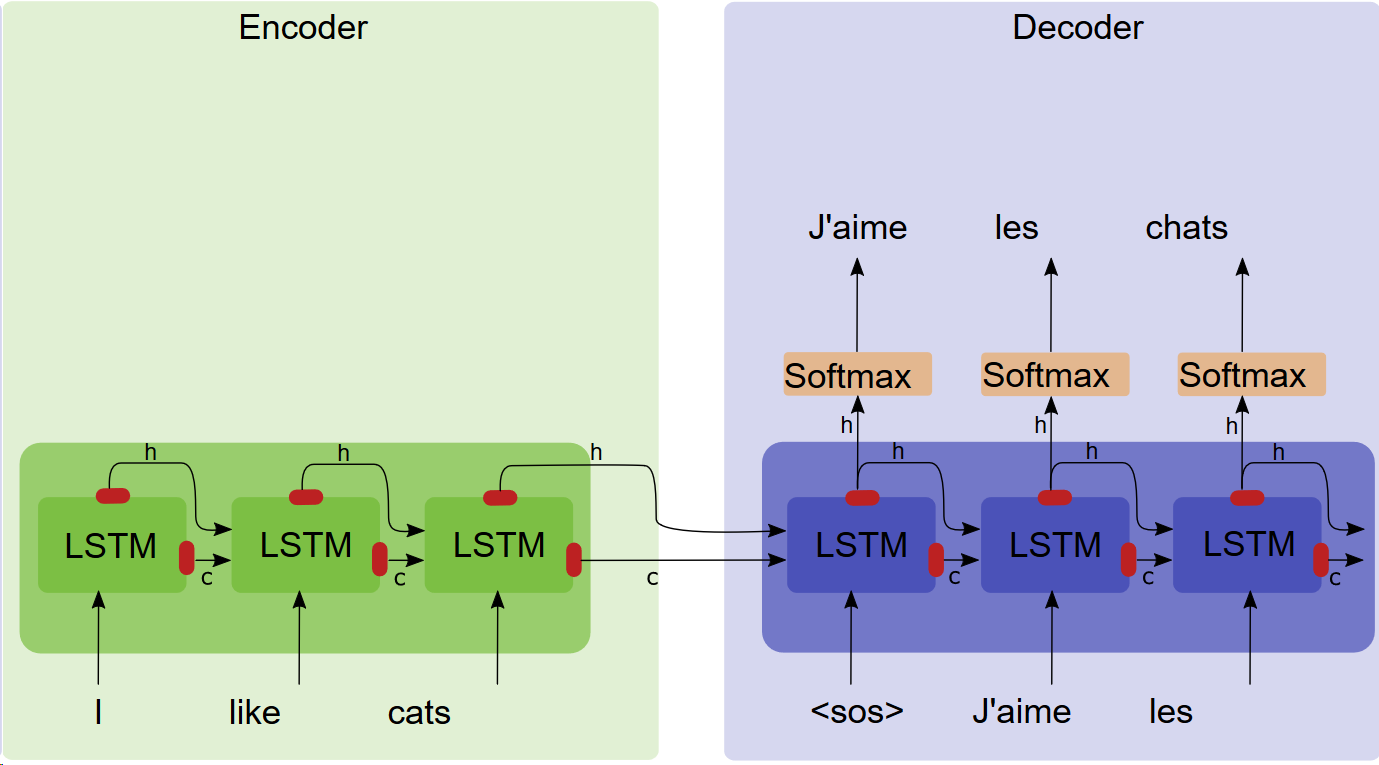

In [21]:
from IPython.display import Image
Image(filename='local/imgs/EDA.png', width=1200)
#![alt text](./Images/EDA.png "Encoder-Decoder")

Image taken from: https://towardsdatascience.com/light-on-math-ml-attention-with-keras-dc8dbc1fad39

This model is able to deal with input and output sequences of different length!

In [33]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [34]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 53]), TensorShape([64, 51]))

In [35]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, spanish_vocab_size):
  
    learning_rate = 0.001
    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size, output_dim=64, input_length=input_shape[1])) 
    model.add(Bidirectional(LSTM(256, return_sequences = False)))
    model.add(RepeatVector(output_sequence_length))
    model.add(LSTM(256, return_sequences = True))
    model.add(TimeDistributed(Dense(spanish_vocab_size, activation = 'softmax')))
    
    model.compile(loss = 'sparse_categorical_crossentropy', 
                 optimizer = Adam(learning_rate))
    return model


encodeco_model = encdec_model(
    input_tensor_train.shape,
    target_tensor_train.shape[1],
    vocab_inp_size,
    vocab_tar_size)

encodeco_model.fit(dataset, epochs=50, verbose=1)

Epoch 1/50
1487/1487 [==============================] - 78s 51ms/step - loss: 1.5090
Epoch 2/50
1487/1487 [==============================] - 75s 50ms/step - loss: 0.9854
Epoch 3/50
1487/1487 [==============================] - 72s 49ms/step - loss: 0.9288
Epoch 4/50
1487/1487 [==============================] - 71s 48ms/step - loss: 0.8489
Epoch 5/50
1487/1487 [==============================] - 71s 48ms/step - loss: 0.7870
Epoch 6/50
1487/1487 [==============================] - 71s 48ms/step - loss: 0.7361
Epoch 7/50
1487/1487 [==============================] - 71s 48ms/step - loss: 0.6871
Epoch 8/50
1487/1487 [==============================] - 71s 48ms/step - loss: 0.6398
Epoch 9/50
1487/1487 [==============================] - 71s 48ms/step - loss: 0.5965
Epoch 10/50
1487/1487 [==============================] - 68s 46ms/step - loss: 0.5552
Epoch 11/50
1487/1487 [==============================] - 69s 47ms/step - loss: 0.5217
Epoch 12/50
1487/1487 [==============================] - 72s 48

In [36]:
encodeco_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 64)            1586816   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               657408    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 51, 512)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 51, 256)           787456    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 51, 12934)         3324038   
Total params: 6,355,718
Trainable params: 6,355,718
Non-trainable params: 0
_________________________________________________________________


In [37]:
sentence = u'hace mucho frio en este lugar.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,encodeco_model)
print(result)

<start> hace mucho frio en este lugar . <end>
<start> it artist is cold this this this . <end> 


In [38]:
sentence = u'esta es mi vida.'
print(preprocess_sentence(sentence))
result = evaluate1(sentence,encodeco_model)
print(result)

<start> esta es mi vida . <end>
<start> this is my life . <end> 


## Neural machine translation with attention

One of the problems of the previous model is the fact that the model has to memorize the entire sentence before start to translate it. The attention model introduces and additional layer that weight the contribution of the first bidirectional RNN layer's outputs to be feed into the last recurrent layer.


Dzmitry Bahdanau, Kyunghyun Cho, Yoshua Bengio , Neural Machine Translation by Jointly Learning to Align and Translate. https://arxiv.org/abs/1409.0473

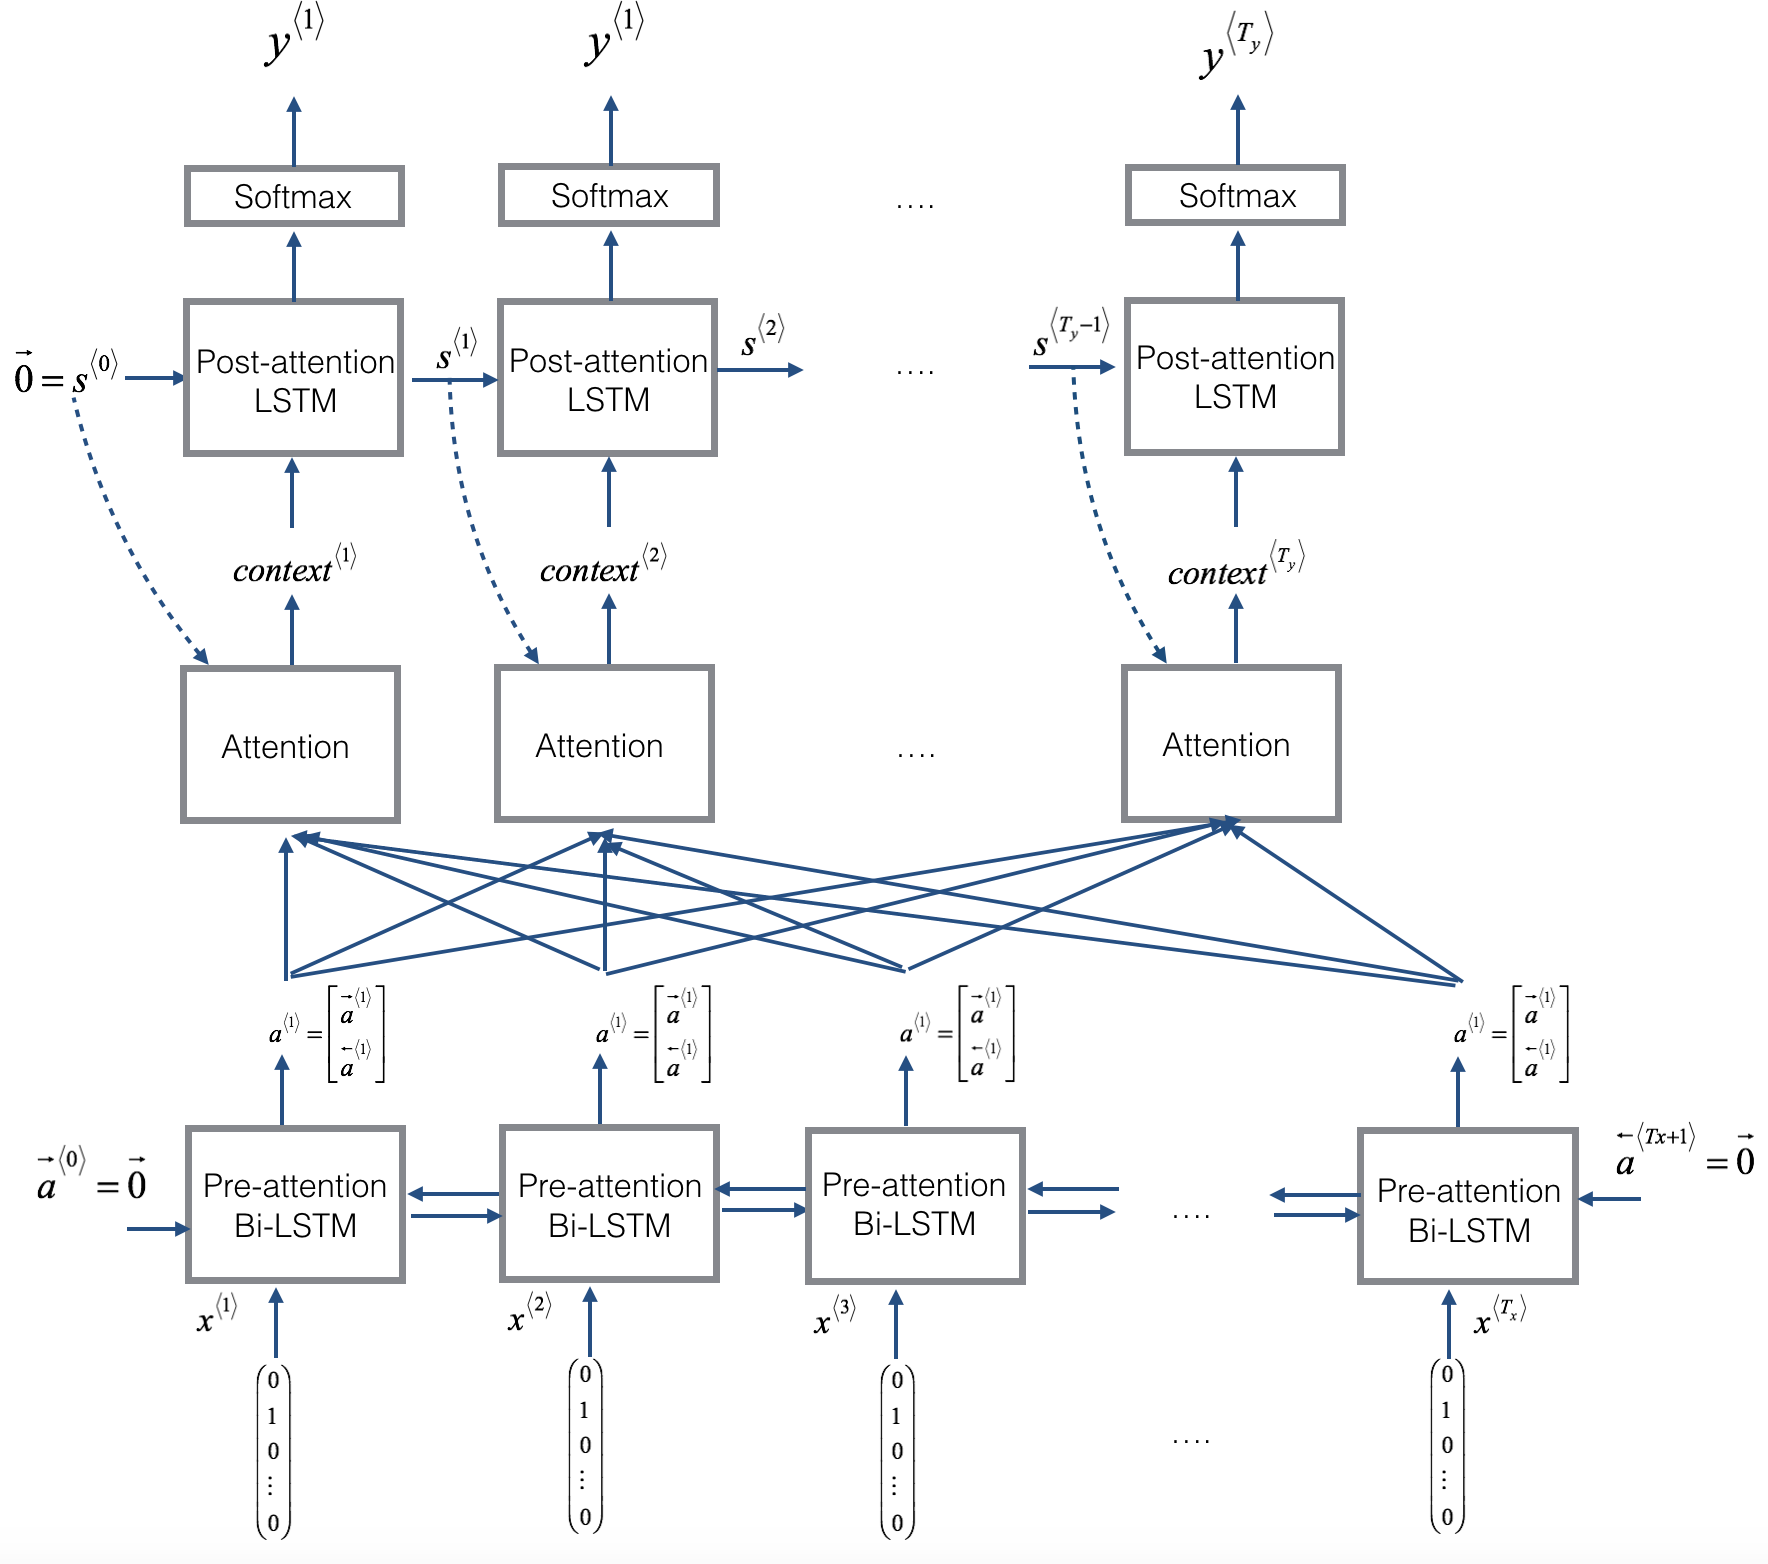

In [27]:
Image(filename='local/imgs/attn_model.png', width=800)

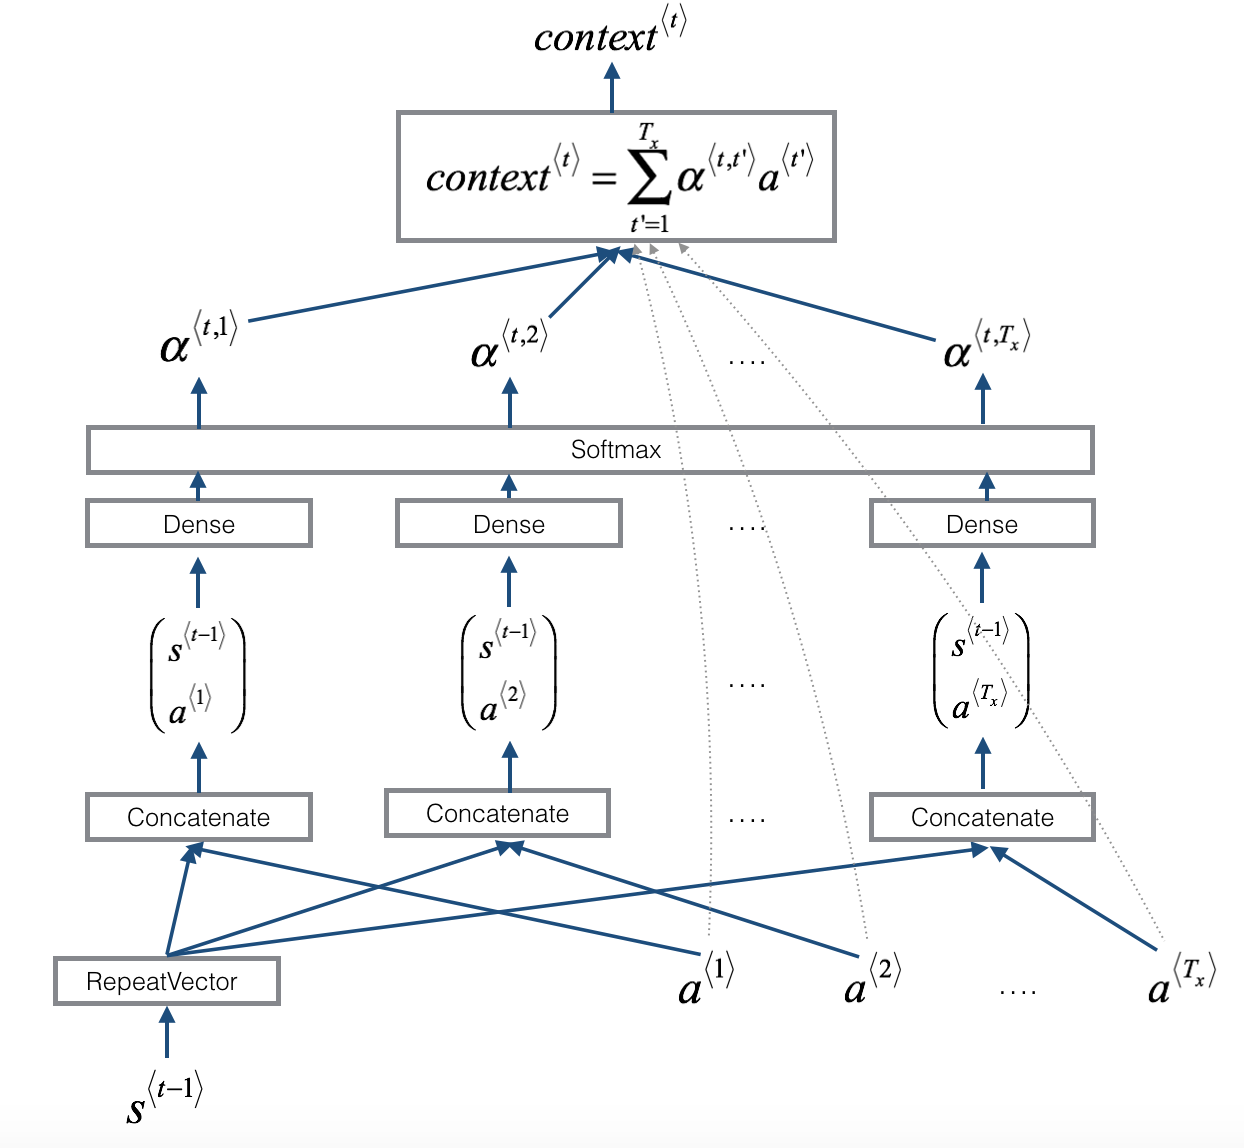

In [26]:
Image(filename='local/imgs/attn_mechanism.png', width=800)

In the following you can see the implementation of the attention model. Each component of the model is defined independently: Encoder, BahdanauAttention and Decoder. During training, the Encoder is called one time, and the decoder is called recursively once per word in the target language. 

Example taken from: [link](https://www.tensorflow.org/tutorials/text/nmt_with_attention) 


In [39]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))


In [40]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 53, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [41]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [42]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 53, 1)


In [43]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights

In [44]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))


Decoder output shape: (batch_size, vocab size) (64, 12934)


In [45]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)


In [46]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [47]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0
    
    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)
        
        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
            loss += loss_function(targ[:, t], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)
            
    batch_loss = (loss / int(targ.shape[1]))
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
            
    return batch_loss

In [48]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 1.7346
Epoch 1 Batch 100 Loss 0.8601
Epoch 1 Batch 200 Loss 0.7552
Epoch 1 Batch 300 Loss 0.8281
Epoch 1 Batch 400 Loss 0.6538
Epoch 1 Batch 500 Loss 0.6904
Epoch 1 Batch 600 Loss 0.5495
Epoch 1 Batch 700 Loss 0.5438
Epoch 1 Batch 800 Loss 0.5842
Epoch 1 Batch 900 Loss 0.5163
Epoch 1 Batch 1000 Loss 0.5993
Epoch 1 Batch 1100 Loss 0.4308
Epoch 1 Batch 1200 Loss 0.4373
Epoch 1 Batch 1300 Loss 0.4032
Epoch 1 Batch 1400 Loss 0.3693
Epoch 1 Loss 0.6021
Time taken for 1 epoch 476.49583768844604 sec

Epoch 2 Batch 0 Loss 0.3239
Epoch 2 Batch 100 Loss 0.2871
Epoch 2 Batch 200 Loss 0.3192
Epoch 2 Batch 300 Loss 0.3301
Epoch 2 Batch 400 Loss 0.2794
Epoch 2 Batch 500 Loss 0.2810
Epoch 2 Batch 600 Loss 0.2682
Epoch 2 Batch 700 Loss 0.2927
Epoch 2 Batch 800 Loss 0.2909
Epoch 2 Batch 900 Loss 0.2823
Epoch 2 Batch 1000 Loss 0.2315
Epoch 2 Batch 1100 Loss 0.2200
Epoch 2 Batch 1200 Loss 0.2360
Epoch 2 Batch 1300 Loss 0.3076
Epoch 2 Batch 1400 Loss 0.2552
Epoch 2 Loss 0.2948
Time ta

In [49]:
def evaluate(sentence):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = preprocess_sentence(sentence)
    
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)
    result = ''
    
    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)
    
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)
    
    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        result += targ_lang.index_word[predicted_id] + ' '
        
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)
    return result, sentence, attention_plot

In [50]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()


In [51]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [52]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui en este momento . <end>
Predicted translation: it is very cold here in this time . <end> 


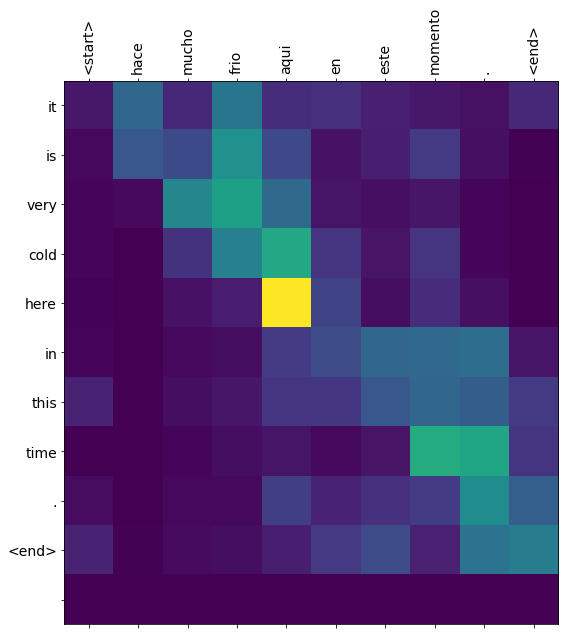

In [53]:
translate(u'hace mucho frio aqui en este momento.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


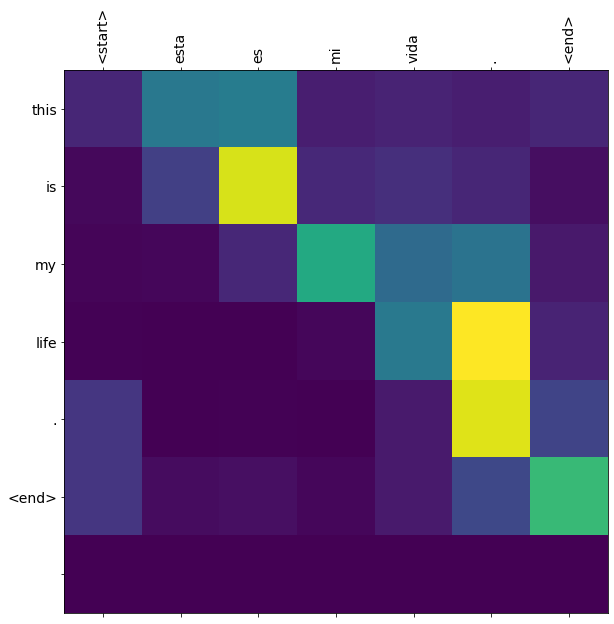

In [54]:
translate(u'esta es mi vida.')

## Metrics in a real context

From: wikipedia

**BLEU (bilingual evaluation understudy)** is an algorithm for evaluating the quality of text which has been machine-translated from one natural language to another. Quality is considered to be the correspondence between a machine's output and that of a human: "the closer a machine translation is to a professional human translation, the better it is" – this is the central idea behind BLEU. BLEU was one of the first metrics to claim a high correlation with human judgements of quality, and remains one of the most popular automated and inexpensive metrics.

Scores are calculated for individual translated segments—generally sentences—by comparing them with a set of good quality reference translations. Those scores are then averaged over the whole corpus to reach an estimate of the translation's overall quality. Intelligibility or grammatical correctness are not taken into account

NLTK provides the sentence_bleu() function for evaluating a candidate sentence against one or more reference sentences.